<p align="center"><img width="50%" src="https://www.modelshare.ai/img/ModelShareLogo_COLOR.abf79305.png" /></p>


---




<p align="center"><h1 align="center">Flower Image Classification Tutorial using Keras</h1> 


## **Create Model Playground ML Project Space: Submit, Track, and Deploy ML Model(s) in about 5 mins**
> ### (1) Set Up Environment 
> ### (2) Create a Model Playground
> ### (3) Submit, Track, and Deploy ML Model(s)
> ### (4) Improve Models and Analyze Model Performance
> ### (5) Maintain Your Model Playground

## **(1) Set Up Environment**

In order to deploy a Model Share AI Model Playground, you will need a credentials text file. 

Generating your credentials file requires two sets of information: 
1. Your Model Share AI username and password (create them [HERE](https://www.modelshare.org/login)). 
2. Your AWS (Amazon Web Services) access keys (follow the tutorial [HERE](https://docs.aws.amazon.com/general/latest/gr/aws-sec-cred-types.html)). 

You only need to generate your credentials file once. After running the configure function below, save the outputted file for all your future Model Playground deployments and competition submissions. 

*Note: Handle your credentials file with the same level of security you handle your passwords. Do not share your file with anyone, send via email, or upload to Github. Model Share AI does not store your credentials.*


In [ ]:
#install aimodelshare library
! pip install aimodelshare --upgrade

In [ ]:
# Generate credentials file
from aimodelshare.aws import configure_credentials 
configure_credentials()

Modelshare.ai Username:··········
Modelshare.ai Password:··········
AWS_ACCESS_KEY_ID:··········
AWS_SECRET_ACCESS_KEY:··········
AWS_REGION:··········
Configuration successful. New credentials file saved as 'credentials.txt'


In [ ]:
# Set credentials 
from aimodelshare.aws import set_credentials
set_credentials(credential_file="credentials.txt", type="deploy_model")

Modelshare.ai login credentials set successfully.
AWS credentials set successfully.


In [ ]:
# Download flower image file (jpg) dataset
import aimodelshare as ai
ai.download_data("public.ecr.aws/y2e2a1d6/flower-competition-data-repository:latest")


Data downloaded successfully.


In [ ]:
# Extract filepaths to use to import and preprocess image files...
base_path = 'flower-competition-data/train_images'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Load file paths to fnames list object...
import os

fnames = []

for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

#print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:4]) # Examples of file names...

## **(2) Create a Model Playground**

### **Create a Model Playground**


> ### Each Model Playground is a unique ML project space with lots of useful functionality...
- Use playground.submit_model() to track ML models in experiments and/or competition leaderboards
- Save, version, and reuse ML models each time they are submitted
- Use playground.compare_models() to compare model architectures with git like colorized model diffs
- Use playground.deploy_model() to deploy models instantly into live REST APIs and/or web-apps.  

*  *First, you need to intantiate a ModelPlayground() object locally. Please specify the data type of your learning task (e.g., image, tabular, etc), whether the model is a classification or a regression model, and whether your playground should be public or private. If you choose "private" only approved team members can interact your model playground*  
*  *Second, you can to create a playground page on the modelshare.ai website. You need to submit evaluation data that submitted models can be evaluated against.*  



In [ ]:
# Instantiate Model Playground object
from aimodelshare.playground import ModelPlayground
myplayground=ModelPlayground(input_type="image", 
                             task_type="classification", 
                             private=False)

# Create Model Playground Page on modelshare.ai website
myplayground.create()

Creating your prediction API. (This process may take several minutes.)

[=====================================] Progress: 100% - Complete!                                            

Success! Your Model Playground was created in 62 seconds. 
 Playground Url: "https://w2d7ulq0x5.execute-api.us-east-1.amazonaws.com/prod/m"

You can now use your Model Playground.

Follow this link to explore your Model Playground's functionality
You can make predictions with the Dashboard and access example code from the Programmatic tab.
https://www.modelshare.ai/detail/model:3521

Check out your Model Playground page for more.


##  **3) Submit, Track, and Deploy Model(s)**


### **Write a Preprocessor Function**


> ###   Preprocessing functions play a crucial role in preparing data for your model by converting it into the specific format that is needed to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  



In [ ]:
# Here is a pre-designed preprocessor, but you could also build your own to prepare the data differently
def preprocessor(image_filepath, shape=(192, 192)):
        """
        This function preprocesses reads in images, resizes them to a fixed shape and
        min/max transforms them before converting feature values to float32 numeric values
        required by onnx files.
        
        params:
            image_filepath
                full filepath of a particular image
                      
        returns:
            X
                numpy array of preprocessed image data
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(image_filepath) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize all the images...
        X = np.array(img)
        X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] for keras model.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

### **Prepare Data**

In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform...

# Read in all images from filenames...
preprocessed_image_data = [preprocessor(x) for x in fnames[0] + fnames[1] + fnames[2] + fnames[3] + fnames[4]]

# tf.keras models require object to be an array rather than a list. (vstack converts above list to array object.)
import numpy as np
X = np.vstack(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model.

In [ ]:
X.shape

(2936, 192, 192, 3)

In [ ]:
# Create y training label data made up of correctly ordered labels from file folders...
from itertools import repeat

daisy = list(repeat("daisy", 507)) #i.e.: 507 filenames in daisy folder
dandelion = list(repeat("dandelion", 718))
roses = list(repeat("roses", 513))
sunflowers = list(repeat("sunflowers", 559))
tulips = list(repeat("tulips", 639))

# Combine into single list of y labels...
y_labels = daisy + dandelion + roses + sunflowers + tulips

# Check length, same as X above...
len(y_labels) 

# Need to one-hot encode for Keras. Let's use Pandas...
import pandas as pd
y = pd.get_dummies(y_labels)
display(y)

,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
2931,0,0,0,0,1
2932,0,0,0,0,1
2933,0,0,0,0,1
2934,0,0,0,0,1


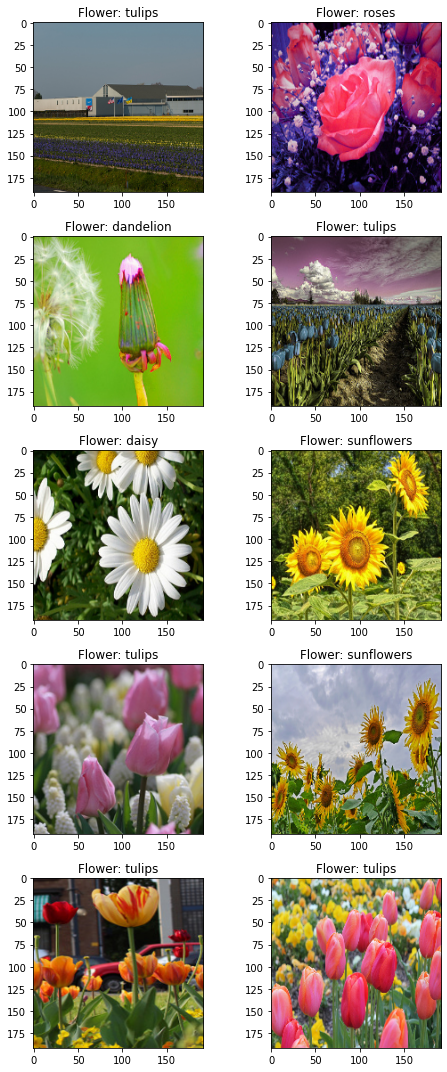

In [ ]:
# Visualize images...
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(5, 2)
fig.set_size_inches(7, 15)
for i in range(5):
    for j in range (2):
        l = np.random.randint(0, len(y_labels))
        ax[i, j].imshow(X[l])
        ax[i, j].set_title('Flower: ' + y_labels[l])
        
plt.tight_layout()

In [ ]:
# train_test_split resized images...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)
y_train 

,daisy,dandelion,roses,sunflowers,tulips
1046,0,1,0,0,0
28,1,0,0,0,0
2615,0,0,0,0,1
6,1,0,0,0,0
1807,0,0,0,1,0
...,...,...,...,...,...
61,1,0,0,0,0
429,1,0,0,0,0
1555,0,0,1,0,0
1077,0,1,0,0,0


In [ ]:
# Create one hot encoded data from list of y_train category labels
#   to allow ModelPlayground.deploy() to extract correct labels for predictions 
import pandas as pd
y_train = pd.get_dummies(y_train)

#ensure column names are correct in one hot encoded target for correct label extraction
list(y_train.columns)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [ ]:
# Create example data folder to provide on model playground page
#     for users to test prediction REST API 

import os 
import shutil

os.mkdir('example_data')
example_images = ["flower-competition-data/train_images/daisy/100080576_f52e8ee070_n.jpg", 
                  "flower-competition-data/train_images/dandelion/10200780773_c6051a7d71_n.jpg", 
                  "flower-competition-data/train_images/roses/10503217854_e66a804309.jpg", 
                  "flower-competition-data/train_images/sunflowers/1022552002_2b93faf9e7_n.jpg", 
                  "flower-competition-data/train_images/tulips/100930342_92e8746431_n.jpg"]
            
for image in example_images:
  shutil.copy(image, 'example_data')

### **Update Evaluation Data**

In [ ]:
# generate list of y_test_labels
y_test_labels = y_test.idxmax(axis=1).tolist()

# update evaluation data
myplayground.update_eval_data(eval_data=y_test_labels)

Your evaluation data has been updated.

Visit your Model Playground Page for more.


### **Train Your Machine Learning Model**


> ### Model Share supports Scikit-Learn, Tensorflow,  Keras, and Pytorch models out of the box.  

*  *Train your model using your favorite ML library. Here, we are training a Keras model.*  
*  *Use your model to make predictions on the test set.*  




In [ ]:
# Let's build a convnet model...
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import tensorflow as tf
with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
                                 
        keras_model = Sequential()
        keras_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=[192, 192, 3]))
        keras_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
        keras_model.add(MaxPooling2D(pool_size=2))

        keras_model.add(Dropout(0.2))
        keras_model.add(Flatten())
        keras_model.add(Dense(16, activation='relu')) # One fully-connected layer of 16 neurons.
        keras_model.add(Dropout(0.2))

        keras_model.add(Dense(5, activation='softmax')) # Last fully-connected layer of 5 outputs (5 categories).

        # Compile model...
        keras_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

        # Fitting the NN to the Training set...
        hist = keras_model.fit(X_train, y_train,
                          epochs=1, verbose=1, validation_data=(X_test, y_test))

74/74 [==============================] - 208s 3s/step - loss: 2.0966 - accuracy: 0.3262 - val_loss: 1.3532 - val_accuracy: 0.4235


In [ ]:
# Check the model architecture.
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      4128      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 96, 96, 32)        0         
                                                                 
 flatten (Flatten)           (None, 294912)            0         
                                                                 
 dense (Dense)               (None, 16)                4718608   
                                                        

In [ ]:
# Generate predicted y values
prediction_column_index=keras_model.predict(X_test).argmax(axis=1)

# Extract correct prediction labels 
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

19/19 [==============================] - 14s 720ms/step


### **Submit a Model to your Model Playground**


> ### You can submit models to your Model Playground page in order to evaluate them, extract model metadata, compare them to other models, and turn them into REST API endpoints.  

*  *Pass your model to the submit model function. You can either pass a model object, an ONNX object, or a filepath to an ONNX file.*  
*  *Pass your preprocessor to ensure that your model can process new data.*
*  *Pass your predictions to be evaluated against your playground evaluation data.*  




In [ ]:
# Submit Model to Experiment Leaderboard
myplayground.submit_model(model=keras_model,
                          preprocessor=preprocessor,
                          prediction_submission=prediction_labels)


Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 1.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3521


### **Deploy a Model to a Prediction REST API and Web-app**


> ### Update the prediction API behind your Model Playground with a new model and verify the model performance metrics in your Model Playground.

Use playground.deploy_model() with the following key arguments:
* *model_version: Simply refer to the model by its leaderboard version number.*
* *example_data: deploy_model builds a web-app for you.  It needs some example data for end users to download to try your web-app.  For image data provide the path to a folder with some example images.* 
*  *y_train: For classification problems deploy_model needs well ordered y_training data labels.  Provide a python list of y_train labels or a one hot encoded Pandas y_training data frame, so your web-app and prediction api return the correct prediction labels*

In [ ]:
# Deploy model by version number
myplayground.deploy_model(model_version=1, 
                          example_data="example_data", 
                          y_train=y_train)

Runtime model & preprocessor for api: https://w2d7ulq0x5.execute-api.us-east-1.amazonaws.com/prod/m updated to model version 1.

Model metrics are now updated and verified for this model playground.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3521


## **(4) Improve Models and Analyze Model Performance**

### **Set Submission Credentials**

> ### Authorized users can submit new models after setting credentials using modelshare.ai username/password.  

*  *This only needs to be done if you want to submit models in a new session.*  
*  *Skip this step if you have already set your deployment credentials.*  




In [ ]:
# example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m
apiurl=myplayground.playground_url 

set_credentials(apiurl=apiurl)

Modelshare.ai Username:··········
Modelshare.ai Password:··········
Modelshare.ai login credentials set successfully.


### **Submit More Models to your Model Playground**


> ### You can submit models to your Model Playground page in order to evaluate them, extract model metadata, compare them to other models, and turn them into REST API endpoints.  

*  *Pass your model to the submit model function. You can either pass a model object, an ONNX object, or a filepath to an ONNX file.*  
*  *Pass your preprocessor to ensure that your model can process new data.*
*  *Pass your predictions to be evaluated against your playground evaluation data.*  


In [ ]:
# Create model 2 

with tf.device('/device:GPU:0'): # "/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      keras_model_2 = Sequential()
      keras_model_2.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      keras_model_2.add(Dense(64, activation='relu'))
      keras_model_2.add(Dense(64, activation='relu'))
      keras_model_2.add(Flatten())
      keras_model_2.add(Dense(5, activation='softmax')) 
                                                  
      # Compile model
      keras_model_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

      # Fitting the NN to the Training set
      keras_model_2.fit(X_train, y_train, 
                    epochs = 1, verbose=1,validation_data=(X_test,y_test))
    

74/74 [==============================] - 337s 5s/step - loss: 4.8610 - accuracy: 0.4118 - val_loss: 1.2627 - val_accuracy: 0.4371


In [ ]:
# Have a look at architecture for model 2
keras_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 192, 192, 64)      256       
                                                                 
 dense_3 (Dense)             (None, 192, 192, 64)      4160      
                                                                 
 dense_4 (Dense)             (None, 192, 192, 64)      4160      
                                                                 
 flatten_1 (Flatten)         (None, 2359296)           0         
                                                                 
 dense_5 (Dense)             (None, 5)                 11796485  
                                                                 
Total params: 11,805,061
Trainable params: 11,805,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Submit Model 2

# Generate predicted y values (Model 2)
prediction_column_index=keras_model_2.predict(X_test).argmax(axis=1)

# extract correct prediction labels (Model 2)
prediction_labels = [y_train.columns[i] for i in prediction_column_index]

# Submit Model 2 to Experiment Leaderboard
myplayground.submit_model(model = keras_model_2,
                          preprocessor=preprocessor,
                          prediction_submission=prediction_labels)

19/19 [==============================] - 24s 1s/step

Insert search tags to help users find your model (optional): 
Provide any useful notes about your model (optional): 
Your model has been submitted to experiment as model version 2.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3521


### **Check Experiment Leaderboard**


> ### Leaderboards allow you to compare model architectures ranked by predictive performance.  

*  *Query leaderboard data for models submitted to your Model Playground page.* 
*  *You can either stylize the leaderboard or use pandas to run your own analyses to explore which model architectures perform well.*  




In [ ]:
# Check experiment leaderboard
data = myplayground.get_leaderboard()
myplayground.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,model_type,depth,num_params,maxpooling2d_layers,conv2d_layers,dropout_layers,dense_layers,flatten_layers,softmax_act,relu_act,loss,optimizer,memory_size,username,version
0,45.92%,46.95%,51.74%,45.75%,keras,Sequential,5,11805061,nan,nan,nan,4,1,1,3,str,RMSprop,47221344,hp2500test,2
1,24.49%,7.87%,4.90%,20.00%,keras,Sequential,8,4723237,1.000000,2.000000,2.000000,2,1,1,3,str,RMSprop,18894112,hp2500test,1


### **Compare Two or More Models**


> ### Model comparisons can help you to identify differences in model architecture at a glance.  

*  *Simply pass the version numbers of the models you would like to compare.* 
*  *For Keras and Pytoch models you can compare architectures through color-coded layer types. For Scikit-Learn models, you can compare hyperparameter settings.*  

In [ ]:
# Compare two or more models
data=myplayground.compare_models([1,2], verbose=1)
myplayground.stylize_compare(data)

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_2_Layer,Model_2_Shape,Model_2_Params
0,Conv2D,"[None, 192, 192, 32]",416,Dense,"[None, 192, 192, 64]",256.000000
1,Conv2D,"[None, 192, 192, 32]",4128,Dense,"[None, 192, 192, 64]",4160.000000
2,MaxPooling2D,"[None, 96, 96, 32]",0,Dense,"[None, 192, 192, 64]",4160.000000
3,Dropout,"[None, 96, 96, 32]",0,Flatten,"[None, 2359296]",0.000000
4,Flatten,"[None, 294912]",0,Dense,"[None, 5]",11796485.000000
5,Dense,"[None, 16]",4718608,None,None,nan
6,Dropout,"[None, 16]",0,None,None,nan
7,Dense,"[None, 5]",85,None,None,nan


### **Check the Structure of Evaluation Data**

> ### Your team needs to understand the format of the evaluation data, to ensure that their submissions can be processed.  

*  *Make sure class labels, data types, and dimensions of predictions correspond to submitted evaluation data.*
*  *This is important to generate evaluation metrics for your submission.*


In [ ]:
# Check structure of evaluation data
myplayground.inspect_eval_data()

{'ytest_example': ['roses', 'roses', 'roses', 'dandelion', 'roses'],
 'y_length': 588,
 'class_labels': ['sunflowers', 'daisy', 'dandelion', 'roses', 'tulips'],
 'class_balance': {'roses': 103,
  'dandelion': 144,
  'daisy': 101,
  'sunflowers': 112,
  'tulips': 128},
 'label_dtypes': {"<class 'str'>": 588}}

## **(5) Maintaining Your Model Playground**

### **Update the Runtime Model (the model that is used for predictions in your REST API/Web-App**


> ### You can update the runtime model anytime by picking one of the previously submitted models.  

* *Simply refer to the model by its leaderboard version number.*
* *You can choos a model from the Competition or Experiment leaderboard by specifying the submission_type argument.*

In [ ]:
# Update runtime model
myplayground.update_runtime_model(model_version=2)

Runtime model & preprocessor for api: https://pgg4133xpc.execute-api.us-east-1.amazonaws.com/prod/m updated to model version 2.

Model metrics are now updated and verified for this model playground.

Visit your Model Playground Page for more.
https://www.modelshare.ai/detail/model:3517


### **Delete Deployment**


> ### You can delete the entire Model Playground, including the REST API, web dashboard, competition, and all submitted models.  

* *This is final - there is no way to recover your Model Playground if you delete it.*
* *We have commented the line for safety reasons.*

In [ ]:
#myplayground.delete_deployment()